# What is pants?

I have started this project to understand how segmentation models work. Identifying and segmenting pants in an image is a fairly easy task for humans — we can do it with almost 100% accuracy. But how well can machines do this task? To answer this existential question, I decided to train a segmentation model and run some predictions. My first choice was the Ultralytics YOLOv8 segmentation model, because it's well-documented, open-source, and looks quite promising. To read more about the whole project, please check: 


## Setting up Google Colab env
If you're running this as a Jupyter notebook from an already cloned git repository, feel free to skip this section.

In [ ]:
%%bash
# clone the repo
!git clone https://github.com/LorenaDerezanin/WhatIsPants.git
%cd WhatIsPants

In [ ]:
%%bash
# install requirements with pip
!pip install -r requirements.txt --no-cache-dir

## Prepare dataset

As our initial dataset we used the Deep Fashion MultiModal dataset: https://github.com/yumingj/DeepFashion-MultiModal    
    * from 44,096 jpg images, 12,701 are annotated (classes, segmentation masks and bounding boxes)

In [8]:
%%bash
# download image files
!wget --header 'Sec-Fetch-Dest: document' \
  'https://drive.usercontent.google.com/download?id=1U2PljA7NE57jcSSzPs21ZurdIPXdYZtN&export=download&authuser=0&confirm=t&uuid=115a0cd6-8ddb-427b-9343-62b76c4d939c&at=APZUnTWiXg4LlG3A7QPA5DmjASX8%3A1715537567680' \
  --output-document 'images.zip'

--2024-05-20 21:47:08--  https://drive.usercontent.google.com/download?id=1U2PljA7NE57jcSSzPs21ZurdIPXdYZtN&export=download&authuser=0&confirm=t&uuid=115a0cd6-8ddb-427b-9343-62b76c4d939c&at=APZUnTWiXg4LlG3A7QPA5DmjASX8%3A1715537567680
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.181.193
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.181.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6822188210 (6,4G) [application/octet-stream]
Saving to: ‘images.zip’

images.zip          100%[===================>]   6,35G  18,4MB/s    in 7m 50s  

2024-05-20 21:54:58 (13,9 MB/s) - ‘images.zip’ saved [6822188210/6822188210]



In [1]:
%%bash
# download annotation labels
!wget --header 'Sec-Fetch-Dest: document' \
  'https://drive.usercontent.google.com/download?id=1r-5t-VgDaAQidZLVgWtguaG7DvMoyUv9&export=download&authuser=0&confirm=t&uuid=b445e6d2-634c-4b59-96c8-4455c6f117a5&at=APZUnTV7OltdPbT0OB1lUK1FhJO8%3A1715537716467' \
  --output-document 'segm.zip'

--2024-05-20 23:52:33--  https://drive.usercontent.google.com/download?id=1r-5t-VgDaAQidZLVgWtguaG7DvMoyUv9&export=download&authuser=0&confirm=t&uuid=b445e6d2-634c-4b59-96c8-4455c6f117a5&at=APZUnTV7OltdPbT0OB1lUK1FhJO8%3A1715537716467
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.181.193
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.181.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94904514 (91M) [application/octet-stream]
Saving to: ‘segm.zip’

segm.zip            100%[===================>]  90,51M  14,2MB/s    in 6,8s    

2024-05-20 23:52:41 (13,3 MB/s) - ‘segm.zip’ saved [94904514/94904514]



In [2]:
%%bash
# unzip the downloaded segmentation labels
!rm -rf datasets/deepfashion/segm
!rm -rf datasets/deepfashion/labels
!mkdir -p datasets/deepfashion/labels
!unzip -qo segm.zip -d datasets/deepfashion/

In [ ]:
%%bash
# remove data from target directory in preparation for unzipping 
!rm -rf datasets/deepfashion/images

# unzip the downloaded images
# this takes about 2 minutes
# tqdm is used to show a progress bar
!unzip images.zip -d datasets/deepfashion/ | tqdm --desc extracted --unit files --unit_scale --total 44097 > /dev/null

### Convert masks to contours format that YOLO can process

In [6]:
import concurrent.futures
import numpy as np
import os
from tqdm import tqdm

# import the mask2contour function 
from mask_2_contour import mask2contour

masks_dir = "datasets/deepfashion/segm"
labels_dir = "datasets/deepfashion/labels"

# define the mask color for pants
# pants are marked with a light gray color in mask files
pants_mask_color = np.array([211, 211, 211])

# Get the number of available CPUs
num_cpus = os.cpu_count()

mask_files = os.listdir(masks_dir)

# load labelled mask pngs
# parallelize processing
with tqdm(total=len(mask_files)) as pbar:
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_cpus) as executor:
        futures = {
            executor.submit(mask2contour, mask_filename, masks_dir, labels_dir, pants_mask_color): mask_filename
            for mask_filename in mask_files
        }
        results = {}
        for future in concurrent.futures.as_completed(futures):
                arg = futures[future]
                results[arg] = future.result()
                pbar.update(1)

Ignoring 0-area contour found in WOMEN-Skirts-id_00005728-02_4_full_segm.png
Ignoring 0-area contour found in WOMEN-Dresses-id_00001164-04_4_full_segm.png
Ignoring 0-area contour found in WOMEN-Blouses_Shirts-id_00001443-01_4_full_segm.png
Ignoring 0-area contour found in MEN-Shorts-id_00007519-01_1_front_segm.png
Ignoring 0-area contour found in WOMEN-Tees_Tanks-id_00003286-01_7_additional_segm.png


## Subset data into `train`, `val` and `test` sets

Dataset containing all 12,701 labelled images was split into:   
    * train 80%   
    * val 10%  
    * test 10%   

In [7]:
import os
import importlib
import subset_training_data
importlib.reload(subset_training_data)
from subset_training_data import set_up_target_dirs, copy_files_in_parallel

# define working directory and subset size
WORKDIR = '.'
subset_size = 12701

num_train_labels = round(0.8 * subset_size)
num_val_labels = round(0.1 * subset_size)

basedir = os.path.join(WORKDIR, 'datasets', 'deepfashion')
labels_source_dir = os.path.join(basedir, 'labels')
images_source_dir = os.path.join(basedir, 'images')

# setup directories
train_dir, val_dir, test_dir = set_up_target_dirs(basedir)

# copy files in parallel
copy_files_in_parallel(
    labels_source_dir,
    images_source_dir,
    train_dir,
    val_dir,
    test_dir,
    num_train_labels,
    num_val_labels,
    subset_size
)


### Inspect annotations by printing 4x4 set of labelled images

Number of images in dataset: 8924


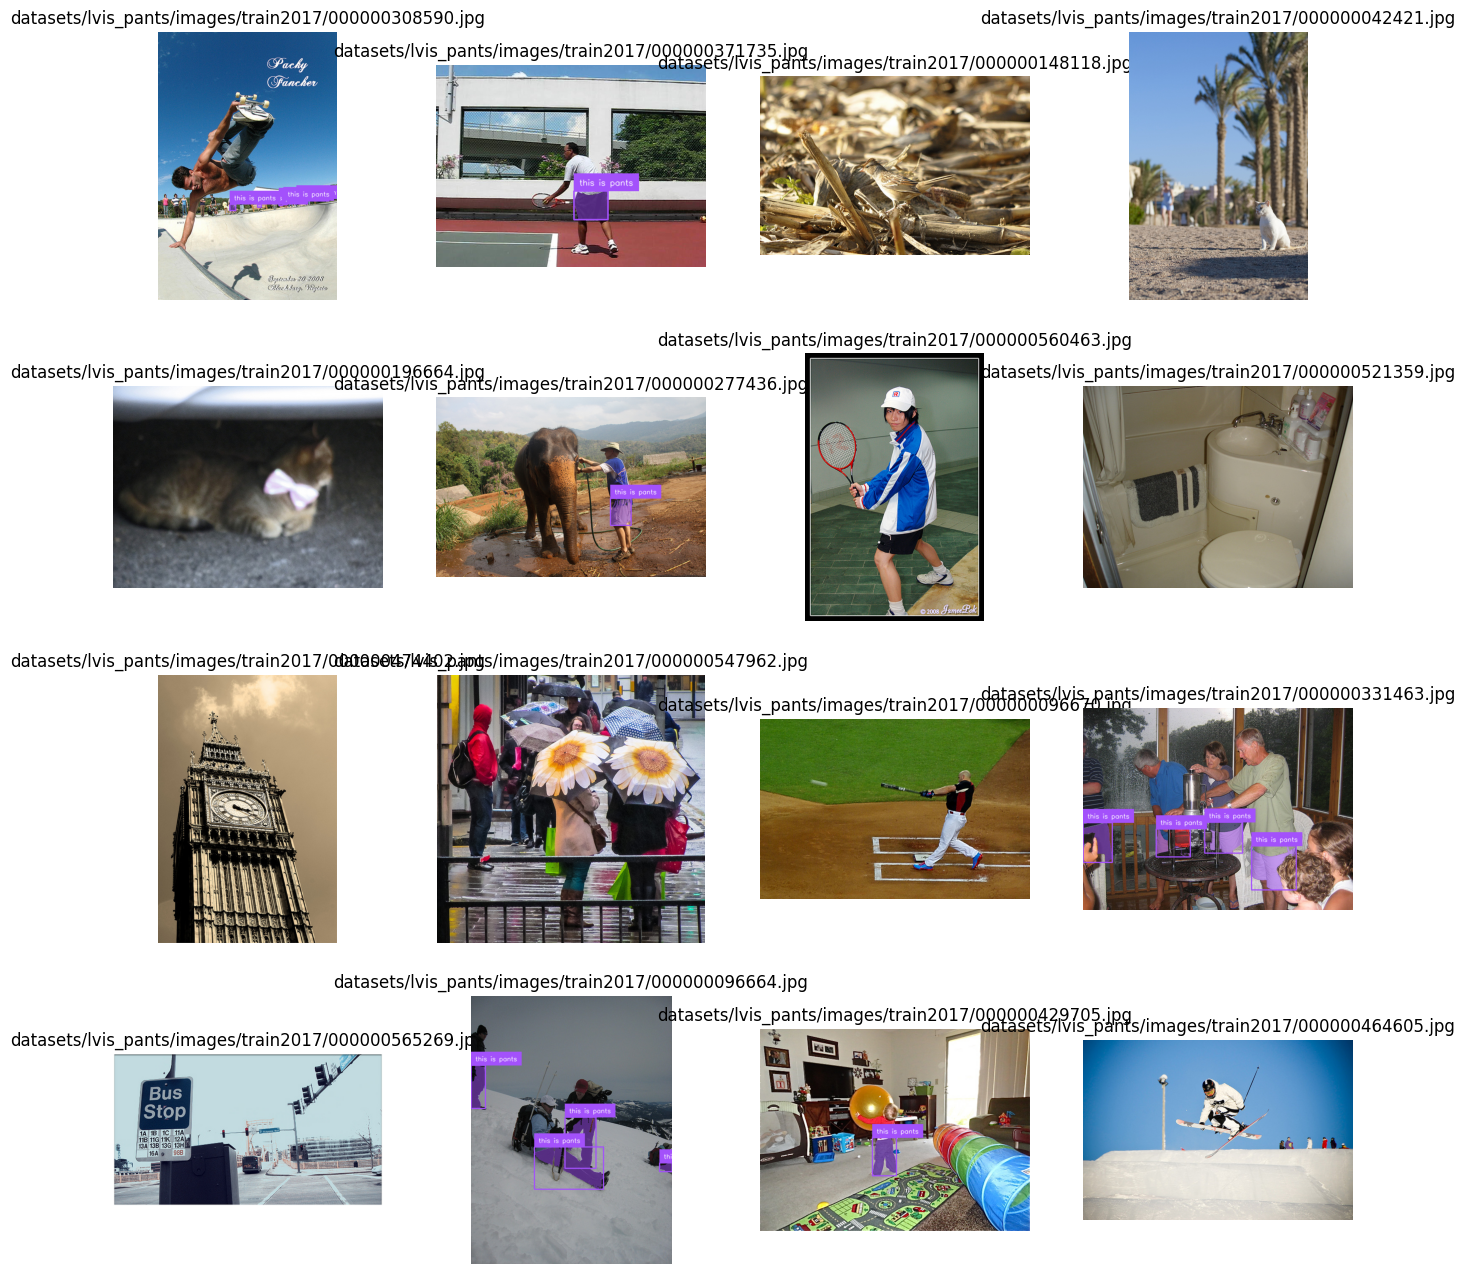

In [8]:
import supervision as sv
from inspect_annotations import load_and_annotate_images, plot_image_grid

# define images, labels and yaml paths, and sample size
IMAGES_DIRECTORY_PATH = "datasets/lvis_pants/images/train2017"
ANNOTATIONS_DIRECTORY_PATH = "datasets/lvis_pants/labels/train2017"
DATA_YAML_PATH = "lvis.yaml"
SAMPLE_SIZE = 16

# load and annotate images
images, image_names = load_and_annotate_images(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH,
    sample_size=SAMPLE_SIZE
)

# plot images grid
plot_image_grid(
    images=images,
    titles=image_names,
    grid_size=(4, 4),
    size=(16, 16)
)

## Find and prepare a more diverse dataset

After a few training and test runs, we noticed that our model is overfitting and not generalizing well.   
To enrich a very uniform initial dataset, we supplemented it with LVIS (Large Vocabulary Instance Segmentation) dataset: https://www.lvisdataset.org/dataset   
to create a more diverse set and prevent overfitting.  
* LVIS is based on the COC0 2017 train, val and test image sets (~160k images with ~2M instance annotations, and 1203 categories).

In [ ]:
# get LVIS dataset
# how did we download lvis

### Copy LVIS images into dir to be subsetted

In [9]:
cp -r ~/datasets/lvis/images datasets/lvis_pants/

### Subset only pants labels

In [1]:
import os
import subprocess
from subset_lvis_pants_labels import subset_labels

# define source and target dirs for training and validation sets
train_source_directory = "datasets/lvis_pants/labels/train2017/"
train_target_directory = "datasets/lvis_pants/labels/train2017/"
val_source_directory = "datasets/lvis_pants/labels/val2017/"
val_target_directory = "datasets/lvis_pants/labels/val2017/"

# subset the training set
subset_labels(train_source_directory, train_target_directory)

# subset the validation set
subset_labels(val_source_directory, val_target_directory)

# check number of resulting non-empty labels
def count_non_empty_files(directory):
    result = subprocess.run(['find', directory, '-type', 'f', '-size', '+0c', '|', 'wc', '-l'], capture_output=True, text=True, shell=True)
    return int(result.stdout.strip())

train_count = count_non_empty_files(train_target_directory)
val_count = count_non_empty_files(val_target_directory)

print(f"Number of non-empty label files in training set: {train_count}")
print(f"Number of non-empty label files in validation set: {val_count}")


Files have been processed and labels adjusted successfully.
Files have been processed and labels adjusted successfully.


ValueError: invalid literal for int() with base 10: ''

### Keep only as many pantsless images as there are pantsful images

In [ ]:
from remove_superfluous_empty_labels import remove_empty_labels

# define dirs for training and validation sets
train_labels_directory = "datasets/lvis_pants/labels/train2017"
train_images_directory = "datasets/lvis_pants/images/train2017
val_labels_directory = "datasets/lvis_pants/labels/val2017"
val_images_directory = "datasets/lvis_pants/images/val2017"

# remove empty labels in training set
remove_empty_labels(train_labels_directory, train_images_directory)

# remove empty labels in validation set
remove_empty_labels(val_labels_directory, val_images_directory)

# verify that empty labels have been removed by counting remaining label files
def count_files(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

train_label_count = count_files(train_labels_directory)
val_label_count = count_files(val_labels_directory)

print(f"Number of label files in training set after removal: {train_label_count}")
print(f"Number of label files in validation set after removal: {val_label_count}")


### Remove images which have no corresponding label file

We observed that the LVIS dataset contains images with pants where pants are not annotated. For example: 000000096670.jpg shows a baseball player, and the labels include a baseball, a home base, a bat, and a belt, but no pants.

In [ ]:
# Assuming delete_labelless_images.py is in the same directory or properly installed in Python's path
from delete_labelless_images import delete_unlabeled_images

# Define the directories
images_dir = 'datasets/lvis_pants/images/train2017'
labels_dir = 'datasets/lvis_pants/labels/train2017'

# Call the function and get the count of deleted files
deleted_files_count = delete_unlabeled_images(images_dir, labels_dir)
print(f"Total deleted images: {deleted_files_count}")

### Prepare `train` configuration yaml file 

We kept only one class in the config yaml (0: This is pants) and removed other object classes.   
Tensorboard set to `true` in yaml to monitor model training and validation performance.

## Run the training

We ran multiple training runs with diffferent configurations:   
    * yolo model sizes: s, m, x    
    * number of epochs: 5, 50, 100    
    * total number of runs: 9    
    
We found that the precision and recall reached a plateau both in train and val stages around 50th epoch and remained fairly stable until 100th epoch. Same goes for box, class and segmetation loss. Model size s performed a bit more poorly than the larger models.   
Comparing the same metrics between model sizes m and x for the same number of epochs was only marginally higher for the larger model x.    
Based on these metrics, we concluded that yolo model size m with 50 epochs is an optimal strategy for this task.   

In [ ]:
# import train function
from lvis_yolo_train import train_yolo_model

# define parameters
EPOCHS = 50
SIZE = 'm'
YAML = 'lvis_fash.yaml'

# train YOLO model
train_yolo_model(epochs=EPOCHS, size=SIZE, yaml=YAML)

### Test the model 

We used a prepared test set to run inferences with our new model.

In [ ]:
yolo segment predict model=best.pt source='dataset/test_images/*'